In [1]:
# std library
from datetime import datetime, timedelta

# local
import ryvkin_model

# third-party
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# test robustness of `inv_gamma` function
z = 3000000
u = ryvkin_model.aux_fn_invgamma(z)
print(u)
ryvkin_model.aux_fn_gamma(u), z

0.9999998333328945


(3000000.0019250414, 3000000)

In [ ]:
# Find the optimal approximation form in the sense of infinity norm
def approx(a: float, xmin: float=-10, xmax:float=10, xstep:float=1e-3):
	z_arr = np.arange(xmin, xmax, xstep)
	invgamma_arr = np.zeros_like(z_arr)
	invgamma_arr_approx = np.zeros_like(z_arr)
	for idx_z, z in enumerate(z_arr):
		invgamma_arr[idx_z] = ryvkin_model.aux_fn_invgamma(float(z))
		invgamma_arr_approx[idx_z] = np.arctan(z * a) * 2 / np.pi
	norm_inf = max(np.abs(invgamma_arr - invgamma_arr_approx))
	return norm_inf, z_arr, invgamma_arr, invgamma_arr_approx

def a_error(a):
	norm_inf, _, _, _ = approx(a)
	return norm_inf

# result: x = 0.8555801631712807
# optimize.minimize_scalar(a_error, bracket=(0.5, 1.5))

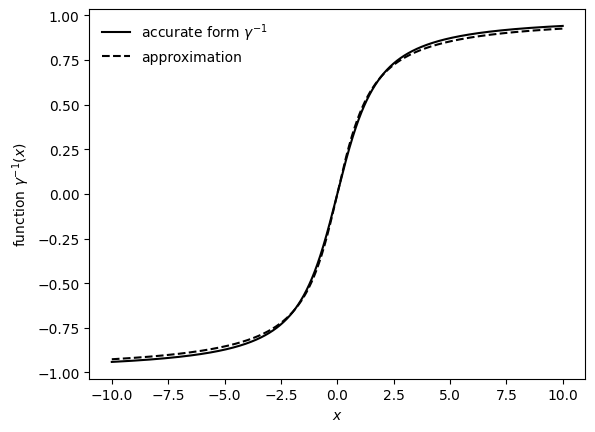

In [4]:
_, z_arr, invgamma_arr, invgamma_arr_approx = approx(0.86)

plt.plot(z_arr, invgamma_arr, label=r'accurate form $\gamma^{-1}$', color='black', linestyle='solid')
plt.plot(z_arr, invgamma_arr_approx, label=r'approximation', color='black', linestyle='dashed')
plt.xlabel(r'$x$')
plt.ylabel(r'function $\gamma^{-1}(x)$')
plt.legend(frameon=False)
plt.savefig('../paper/approx_invgamma.pdf', bbox_inches='tight')
plt.show()

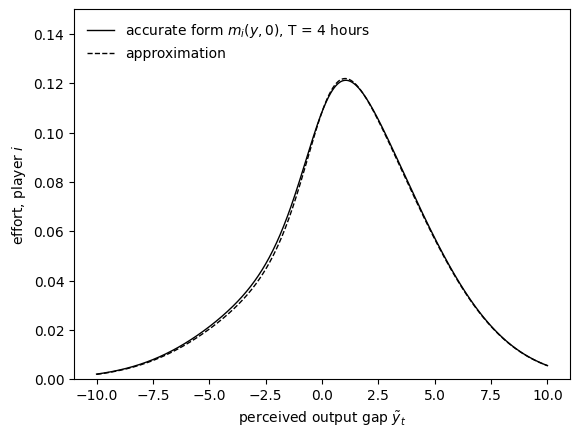

In [ ]:
# Test correctness
#
state_space_y = np.linspace(-10, 10, 1001)

time_step = 1 / 24
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 1, 1, 4, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timegrids = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=np.datetime64)

equilibrium_graph = np.zeros(
	shape=(contest_timegrids.shape[0], len(state_space_y), 2),
	dtype=np.float64
)
equilibrium_graph_approx = np.zeros_like(equilibrium_graph)

for idx_t, t in enumerate(contest_timegrids[:2]):
	for idx_y, y in enumerate(state_space_y):
		qi, qj = ryvkin_model.get_equilibrium_efforts(
			y, t, end_time,
			prize=1, c_i=1, c_j=1, sigma=1)
		qi_approx, qj_approx = ryvkin_model.get_equilibrium_efforts(
			y, t, end_time,
			prize=1, c_i=1, c_j=1, sigma=1, approx=True)
		equilibrium_graph[idx_t, idx_y] = (qi, qj)
		equilibrium_graph_approx[idx_t, idx_y] = (qi_approx, qj_approx)

plt.ylim(0, 0.15)
plt.plot(state_space_y, equilibrium_graph[0, :, 0],
		label=fr'accurate form $m_i(y, 0)$, T = 4 hours',
		linewidth=1, color = 'black', linestyle='solid')
plt.plot(state_space_y, equilibrium_graph_approx[0, :, 0],
		label=fr'approximation',
		linewidth=1, color = 'black', linestyle='dashed')

# plt.plot(state_space_y, equilibrium_graph[0, :, 1], label=f'q_j, time = {0}, T = {end_time}',
# 		linewidth=1, color = 'black', linestyle='dashed')
# plt.plot(state_space_y, equilibrium_graph[1, :, 0], label=f'q_i, time = {1}, T = {end_time}',
# 		linewidth=2, color = 'black', linestyle='solid')
# plt.plot(state_space_y, equilibrium_graph[1, :, 1], label=f'q_j, time = {1}, T = {end_time}',
# 		linewidth=2, color = 'black', linestyle='dashed')
plt.xlabel(r'perceived output gap $\tilde{y}_t$')
plt.ylabel(r'effort, player $i$')
plt.legend(frameon=False, loc='upper left')
plt.savefig('../paper/approx_equi_effort.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Test robustness
# If `sigma` is sufficiently large, the numerical solution is robust
#
qi, qj = ryvkin_model.get_equilibrium_efforts(y, t, T=end_time,
		prize=30,
		c_i=1,
		c_j=1,
		sigma=1
)
qi, qj

(np.float64(0.00999157733307539), np.float64(9.087286646794816e-15))